In [1]:
# Folder setup
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/MLGO" "/content/MLGO"

In [1]:
import os
os.chdir("/content/MLGO")

In [2]:
!git config --global core.fileMode false
!git config --global user.email "colab@google"
!git config --global user.name "Colab"

In [ ]:
# Install packages

In [2]:
# Imports for ML
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf

# Other third-party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

# Imports from standard library
import glob

# Read config
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
# Load data
with np.load(f"{config['path']['final']}/labels.npz", allow_pickle=True) as D:
    labels = D['labels']
    features = D['features']
    samples = D['samples']

with np.load(f"{config['path']['final']}/train.npz") as D:
    X_train, Y_train = D['X'], D['Y']

# with np.load(f"{config['path']['final']}/test.npz") as D:
#     X_test, Y_test = D['X'], D['Y']

with np.load(f"{config['path']['final']}/val.npz") as D:
    X_val, Y_val = D['X'], D['Y']


scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform( X_train )
# X_test = scaler.transform( X_test )
X_val = scaler.transform( X_val )

# Model Development

## Autoencoder

In this section, I will develop an autoencoder model for reconstructing log fold-change values

### Model Parameters

* `ENCODING_DIM` - The encoding dimension is a hyperparameter that determines the size of the bottleneck layer in the autoencoder. It represents the number of neurons in the hidden layer that encodes the input data into a lower dimensional representation.

In [4]:
# Parameters
INPUT_SHAPE = (X_train.shape[1],)
BATCH_SIZE = 128
EPOCHS = 20

In [5]:
# Model Architecture

class AutoEncoder(Model):
    """
    Autoencoder Neural Network
    """

    def __init__(self):
        """Model constructor"""

        super(AutoEncoder, self).__init__()

        self.encoder = Sequential([
            layers.Dense(1000, activation='relu', kernel_regularizer=l2(0.01)),
            layers.Dense(512,  activation='relu'),
            layers.Dense(256,  activation='relu', kernel_regularizer=l2(0.01)),
            layers.Dense(128,  activation='relu'),
        ])

        self.decoder = Sequential([
            layers.Dense(256,  activation='relu', kernel_regularizer=l1(0.01)),
            layers.Dense(512,  activation='relu'),
            layers.Dense(1000, activation='relu', kernel_regularizer=l1(0.01)),
            layers.Dense(INPUT_SHAPE[0], activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AutoEncoder()

## Compile
autoencoder.compile(
    optimizer='adam',
    loss=losses.MAE
)

In [6]:
# Train the network
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_val, X_val)
)

# Calculate reconstruction error
reconstructed = autoencoder.predict(X_val)
mae = losses.MAE(X_val, reconstructed).numpy().mean()
print(f'Reconstruction error (MAE): {mae:.4f}')

Epoch 1/20
36/36 [==============================] - 11s 93ms/step - loss: 110.3534 - val_loss: 44.1526
Epoch 2/20
36/36 [==============================] - 2s 63ms/step - loss: 18.8483 - val_loss: 6.3668
Epoch 3/20
36/36 [==============================] - 2s 63ms/step - loss: 3.3515 - val_loss: 1.3851
Epoch 4/20
36/36 [==============================] - 2s 67ms/step - loss: 1.0229 - val_loss: 0.8072
Epoch 5/20
36/36 [==============================] - 3s 72ms/step - loss: 0.7563 - val_loss: 0.7127
Epoch 6/20
36/36 [==============================] - 2s 67ms/step - loss: 0.6802 - val_loss: 0.6464
Epoch 7/20
36/36 [==============================] - 2s 64ms/step - loss: 0.6342 - val_loss: 0.6294
Epoch 8/20
36/36 [==============================] - 2s 62ms/step - loss: 0.6282 - val_loss: 0.6303
Epoch 9/20
36/36 [==============================] - 2s 63ms/step - loss: 0.6279 - val_loss: 0.6340
Epoch 10/20
36/36 [==============================] - 3s 70ms/step - loss: 0.6278 - val_loss: 0.6290
Epoc

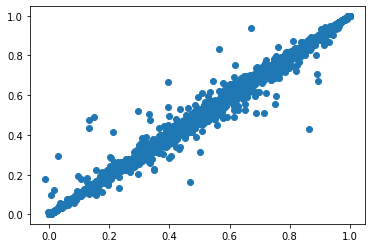

In [18]:
i = 554
plt.plot(X_val[i,:], reconstructed[i,:], 'o')

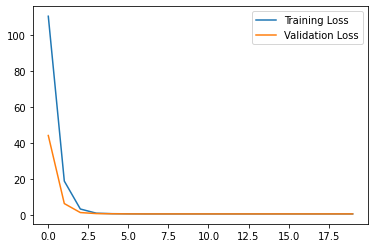

In [8]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()